# Plant Disease Prediction

**November 2022**


Charles Liu

Raza Haji

Syed Sakeeb

Brian Morris


###Introduction

The major risk to food safety is Plant diseases and now it has become important practice to identity plant diseases in the starting phase itself to minimize the crop and financial losses. To overcome this challenge a state of the art Convolution Neural Network is proposed to classify tomato leaf diseases with the help of computer vision.


### Dataset:

The data has different types of diseases for tomato leaves:

    Tomatomosaicvirus
    Target_Spot
    Bacterial_spot
    TomatoYellowLeafCurlVirus
    Late_blight
    Leaf_Mold
    Early_blight
    Spidermites Two-spottedspider_mite
    Tomato___healthy
    Septorialeafspot

https://www.kaggle.com/datasets/kaustubhb999/tomatoleaf


## Import Dependencies

In [ ]:
!pip install lime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 275 kB 26.9 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283858 sha256=b709c71558bfa5f16ee6b47047dc3844dadc0a2b7573b45aac51bc787e2f0516
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from keras.optimizers import Adam, Adadelta, RMSprop
from sklearn.metrics import classification_report, confusion_matrix

# For Model Interpretation Section
import os
import keras
from keras.applications import inception_v3 as inc_net
from keras.applications import imagenet_utils
from tensorflow.keras.preprocessing import image
from skimage.io import imread
from skimage.segmentation import mark_boundaries
from lime.lime_tabular import LimeTabularExplainer
from lime import lime_image

%matplotlib inline
plt.style.use('seaborn')

In [ ]:
print('Notebook run using keras:', keras.__version__)
print('Notebook run using tensorflow:', tf.__version__)

Notebook run using keras: 2.9.0
Notebook run using tensorflow: 2.9.2


#### Dataset:

https://www.kaggle.com/code/aymanokaby/tomoto-classification/data



## Import Dataset

In [ ]:
! pip install -q kaggle

In [ ]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d kaustubhb999/tomatoleaf

 99% 177M/179M [00:08<00:00, 24.2MB/s]
100% 179M/179M [00:09<00:00, 20.8MB/s]


In [ ]:
! unzip tomatoleaf.zip

Streaming output truncated to the last 5000 lines.
  inflating: tomato/train/Tomato___Target_Spot/002213fb-b620-4593-b9ac-6a6cc119b100___Com.G_TgS_FL 8360.JPG  
  inflating: tomato/train/Tomato___Target_Spot/0044d10f-7062-4655-8abd-9fffc5b2f152___Com.G_TgS_FL 7908.JPG  
  inflating: tomato/train/Tomato___Target_Spot/00854623-ba28-446d-a1d5-03c0ae3f99d9___Com.G_TgS_FL 7949.JPG  
  inflating: tomato/train/Tomato___Target_Spot/0118c27a-f34a-41e1-8b2f-d2c564f83c5c___Com.G_TgS_FL 0013.JPG  
  inflating: tomato/train/Tomato___Target_Spot/0118ed61-b135-45be-ad81-7e2d54203be4___Com.G_TgS_FL 8241.JPG  
  inflating: tomato/train/Tomato___Target_Spot/0197df47-a9cb-4b6c-b72c-ac0e9af6d135___Com.G_TgS_FL 0779.JPG  
  inflating: tomato/train/Tomato___Target_Spot/025510ac-15db-4861-b02b-21da82161100___Com.G_TgS_FL 0952.JPG  
  inflating: tomato/train/Tomato___Target_Spot/0288164e-d6cf-4215-b593-7b581308a4cf___Com.G_TgS_FL 9777.JPG  
  inflating: tomato/train/Tomato___Target_Spot/03002b91-afe3-4c72-86b

In [ ]:
# Set training and test data directories
train_dir = '/content/tomato/train'
test_dir = '/content/tomato/val'

In [ ]:
# Loading, Labelling and Shuffling from train and val folder
IMG_SIZE = (256, 256)
BATCH_SIZE = 32
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory = train_dir,
    image_size = IMG_SIZE,
    label_mode = 'categorical',
    batch_size = BATCH_SIZE,
    shuffle = True,
    seed=42
).cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory = test_dir,
    image_size = IMG_SIZE,
    label_mode = 'categorical',
    batch_size = BATCH_SIZE
)

Found 10000 files belonging to 10 classes.
Found 1000 files belonging to 10 classes.


In [ ]:
class_names = test_data.class_names
valid_data = test_data.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

## EDA

In [ ]:
# Our labels
class_names

['Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']

In [ ]:
train_image_names = glob.glob('../content/tomato/train/*/*.JPG')
print("Total number of training images: ", len(train_image_names))

# make train_image_names as serie object
train_image_names = pd.Series(train_image_names)

Total number of training images:  9910


In [ ]:
val_image_names = glob.glob('../content/tomato/val/*/*.JPG')
print("Total number of validation images: ", len(val_image_names))

# make train_image_names as serie object
val_image_names = pd.Series(val_image_names)

Total number of validation images:  995


In [ ]:
print("Tomato___Bacterial_spot train: ", len(os.listdir("../content/tomato/train/Tomato___Bacterial_spot")))
print("Tomato___Early_blight train: ", len(os.listdir("../content/tomato/train/Tomato___Early_blight")))
print("Tomato___Late_blight train: ", len(os.listdir("../content/tomato/train/Tomato___Late_blight")))
print("Tomato___Leaf_Mold train: ", len(os.listdir("../content/tomato/train/Tomato___Leaf_Mold")))
print("Tomato___Septoria_leaf_spot train: ", len(os.listdir("../content/tomato/train/Tomato___Septoria_leaf_spot")))
print("Tomato___Spider_mites Two-spotted_spider_mite train: ", len(os.listdir("../content/tomato/train/Tomato___Spider_mites Two-spotted_spider_mite")))
print("Tomato___Target_Spot train: ", len(os.listdir("../content/tomato/train/Tomato___Target_Spot")))
print("Tomato___Tomato_Yellow_Leaf_Curl_Virus train: ", len(os.listdir("../content/tomato/train/Tomato___Tomato_Yellow_Leaf_Curl_Virus")))
print("Tomato___Tomato_mosaic_virus train: ", len(os.listdir("../content/tomato/train/Tomato___Tomato_mosaic_virus")))
print("Tomato___healthy train: ", len(os.listdir("../content/tomato/train/Tomato___healthy")))
                       

Tomato___Bacterial_spot train:  1000
Tomato___Early_blight train:  1000
Tomato___Late_blight train:  1000
Tomato___Leaf_Mold train:  1000
Tomato___Septoria_leaf_spot train:  1000
Tomato___Spider_mites Two-spotted_spider_mite train:  1000
Tomato___Target_Spot train:  1000
Tomato___Tomato_Yellow_Leaf_Curl_Virus train:  1000
Tomato___Tomato_mosaic_virus train:  1000
Tomato___healthy train:  1000


In [ ]:
print("Tomato___Bacterial_spot val: ", len(os.listdir("../content/tomato/val/Tomato___Bacterial_spot")))
print("Tomato___Early_blight val: ", len(os.listdir("../content/tomato/val/Tomato___Early_blight")))
print("Tomato___Late_blight val: ", len(os.listdir("../content/tomato/val/Tomato___Late_blight")))
print("Tomato___Leaf_Mold val: ", len(os.listdir("../content/tomato/val/Tomato___Leaf_Mold")))
print("Tomato___Septoria_leaf_spot val: ", len(os.listdir("../content/tomato/val/Tomato___Septoria_leaf_spot")))
print("Tomato___Spider_mites Two-spotted_spider_mite val: ", len(os.listdir("../content/tomato/val/Tomato___Spider_mites Two-spotted_spider_mite")))
print("Tomato___Target_Spot val: ", len(os.listdir("../content/tomato/val/Tomato___Target_Spot")))
print("Tomato___Tomato_Yellow_Leaf_Curl_Virus val: ", len(os.listdir("../content/tomato/val/Tomato___Tomato_Yellow_Leaf_Curl_Virus")))
print("Tomato___Tomato_mosaic_virus val: ", len(os.listdir("../content/tomato/val/Tomato___Tomato_mosaic_virus")))
print("Tomato___healthy val: ", len(os.listdir("../content/tomato/val/Tomato___healthy")))

Tomato___Bacterial_spot val:  100
Tomato___Early_blight val:  100
Tomato___Late_blight val:  100
Tomato___Leaf_Mold val:  100
Tomato___Septoria_leaf_spot val:  100
Tomato___Spider_mites Two-spotted_spider_mite val:  100
Tomato___Target_Spot val:  100
Tomato___Tomato_Yellow_Leaf_Curl_Virus val:  100
Tomato___Tomato_mosaic_virus val:  100
Tomato___healthy val:  100


In [ ]:
num_img_class_train = {'Tomato___Bacterial_spot': len(os.listdir("../content/tomato/train/Tomato___Bacterial_spot")), 
                       'Tomato___Early_blight': len(os.listdir("../content/tomato/train/Tomato___Early_blight")), 
                       'Tomato___Late_blight': len(os.listdir("../content/tomato/train/Tomato___Late_blight")), 
                       'Tomato___Leaf_Mold': len(os.listdir("../content/tomato/train/Tomato___Leaf_Mold")), 
                       'Tomato___Septoria_leaf_spot': len(os.listdir("../content/tomato/train/Tomato___Septoria_leaf_spot")), 
                       'Tomato___Spider_mites Two-spotted_spider_mite': len(os.listdir("../content/tomato/train/Tomato___Spider_mites Two-spotted_spider_mite")), 
                       'Tomato___Target_Spot': len(os.listdir("../content/tomato/train/Tomato___Target_Spot")), 
                       'Tomato___Tomato_Yellow_Leaf_Curl_Virus': len(os.listdir("../content/tomato/train/Tomato___Tomato_Yellow_Leaf_Curl_Virus")), 
                       'Tomato___Tomato_mosaic_virus': len(os.listdir("../content/tomato/train/Tomato___Tomato_mosaic_virus")), 
                       'Tomato___healthy': len(os.listdir("../content/tomato/train/Tomato___healthy"))}

In [ ]:
num_img_class_val = {'Tomato___Bacterial_spot': len(os.listdir("../content/tomato/val/Tomato___Bacterial_spot")), 
                       'Tomato___Early_blight': len(os.listdir("../content/tomato/val/Tomato___Early_blight")), 
                       'Tomato___Late_blight': len(os.listdir("../content/tomato/val/Tomato___Late_blight")), 
                       'Tomato___Leaf_Mold': len(os.listdir("../content/tomato/val/Tomato___Leaf_Mold")), 
                       'Tomato___Septoria_leaf_spot': len(os.listdir("../content/tomato/val/Tomato___Septoria_leaf_spot")), 
                       'Tomato___Spider_mites Two-spotted_spider_mite': len(os.listdir("../content/tomato/val/Tomato___Spider_mites Two-spotted_spider_mite")), 
                       'Tomato___Target_Spot': len(os.listdir("../content/tomato/val/Tomato___Target_Spot")), 
                       'Tomato___Tomato_Yellow_Leaf_Curl_Virus': len(os.listdir("../content/tomato/val/Tomato___Tomato_Yellow_Leaf_Curl_Virus")), 
                       'Tomato___Tomato_mosaic_virus': len(os.listdir("../content/tomato/val/Tomato___Tomato_mosaic_virus")), 
                       'Tomato___healthy': len(os.listdir("../content/tomato/val/Tomato___healthy"))}

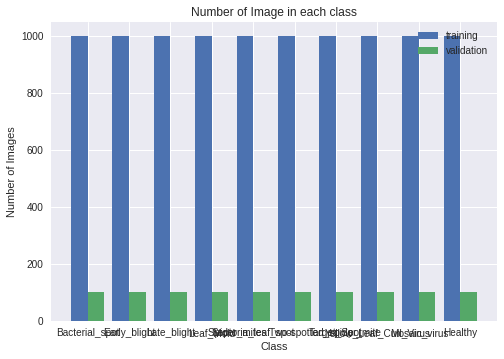

In [ ]:
names = ['Bacterial_spot', 'Early_blight', 'Late_blight', 'Leaf_Mold', 'Septoria_leaf_spot', \
         'Spider_mites Two-spotted_spider_mite', 'Target_Spot', 'Yellow_Leaf_Curl_Virus', 'Mosaic_virus', 'Healthy']

num_train = num_img_class_train.values()
num_val = num_img_class_val.values()

X_axis = np.arange(len(names))
  
plt.bar(X_axis - 0.2, num_train, 0.4, label = 'training')
plt.bar(X_axis + 0.2, num_val, 0.4, label = 'validation')
  
plt.xticks(X_axis, names)
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.title("Number of Image in each class")
plt.legend()
plt.show()

In [ ]:
train_data

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

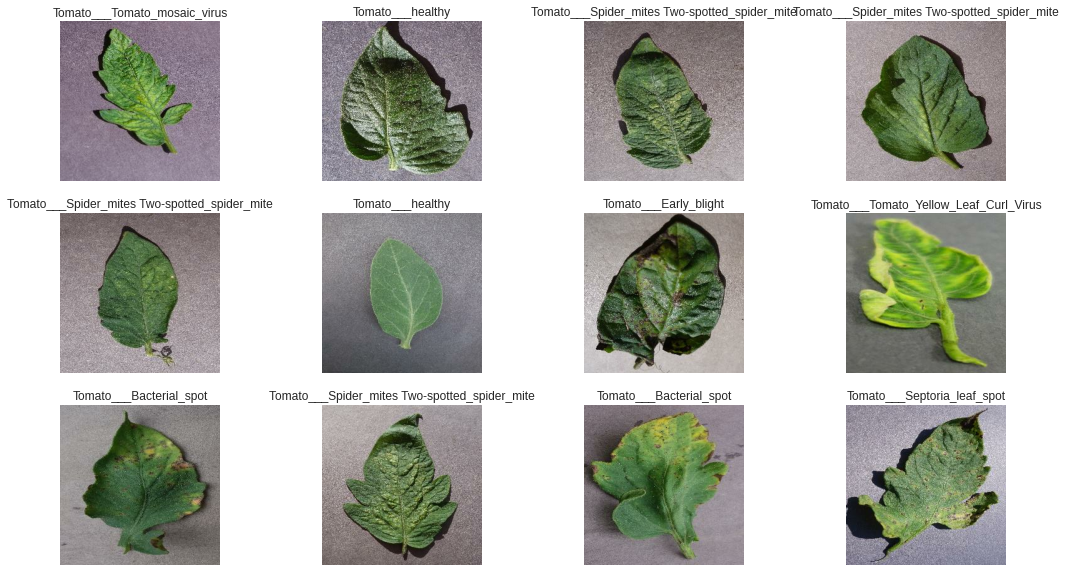

In [ ]:
plt.figure(figsize=(18,10))
for image_batch,label_batch in train_data.take(1):
    for i in range(0,12):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint32"))
        plt.title(class_names[np.argmax(label_batch[i])])
        plt.axis("off")

# Defining the Model with Sequential

In [ ]:
model = Sequential()
# input: 28x28 images with 1 channels -> (28, 28, 1) tensors.
# this applies 32 convolution filters of size 3x3 each.
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3),padding='same'))
model.add(BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"))
model.add(LeakyReLU(alpha=0.1))
model.add(Conv2D(32, (3, 3), activation='relu',padding='same'))
model.add(BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu',padding='same'))
model.add(BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"))
model.add(LeakyReLU(alpha=0.1))
model.add(Conv2D(64, (3, 3), activation='relu',padding='same'))
model.add(BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=5, activation='relu',padding='same'))
model.add(BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"))
model.add(LeakyReLU(alpha=0.1))
model.add(Conv2D(128, kernel_size=5, activation='relu',padding='same'))
model.add(BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


model.add(Conv2D(256, kernel_size=5, activation='relu',padding='same'))
model.add(BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"))
model.add(LeakyReLU(alpha=0.1))
model.add(Conv2D(256, kernel_size=5, activation='relu',padding='same'))
model.add(BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


model.add(Flatten())

model.add(Dense(256, activation='relu', name='my_dense'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

#sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
#model.compile(loss='categorical_crossentropy', optimizer=sgd)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 32)     128       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 256, 256, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 32)      9248      
                                                                 
 batch_normalization_1 (Batc  (None, 256, 256, 32)     128       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 256, 256, 32)      0

# Compiling the Model with Appropriate Optimizers and Metrics

In [ ]:
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = Adam(),
    metrics = ['accuracy']
)

## Model Training

In [ ]:
# Train the model
history = model.fit(
    train_data,
    epochs=50,
    shuffle = True,
    steps_per_epoch=len(train_data),
    validation_data = test_data,
    validation_steps = len(test_data)
)

Epoch 1/50
313/313 [==============================] - 109s 306ms/step - loss: 1.5914 - accuracy: 0.4321 - val_loss: 1.2963 - val_accuracy: 0.5150
Epoch 2/50
313/313 [==============================] - 89s 286ms/step - loss: 1.0400 - accuracy: 0.6543 - val_loss: 1.2951 - val_accuracy: 0.5490
Epoch 3/50
313/313 [==============================] - 90s 287ms/step - loss: 0.8112 - accuracy: 0.7271 - val_loss: 0.8377 - val_accuracy: 0.7150
Epoch 4/50
313/313 [==============================] - 91s 292ms/step - loss: 0.6794 - accuracy: 0.7673 - val_loss: 0.8138 - val_accuracy: 0.7350
Epoch 5/50
313/313 [==============================] - 92s 293ms/step - loss: 0.6235 - accuracy: 0.7896 - val_loss: 1.8644 - val_accuracy: 0.5150
Epoch 6/50
313/313 [==============================] - 90s 289ms/step - loss: 0.5275 - accuracy: 0.8221 - val_loss: 0.6473 - val_accuracy: 0.7840
Epoch 7/50
313/313 [==============================] - 92s 293ms/step - loss: 0.4634 - accuracy: 0.8456 - val_loss: 0.5229 - val_a

## Plotting the Loss and Accuracy vs Epochs Curve on Train and Validation

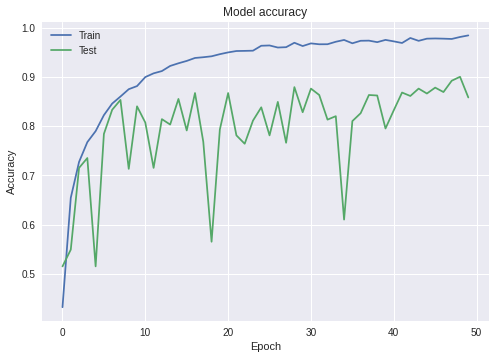

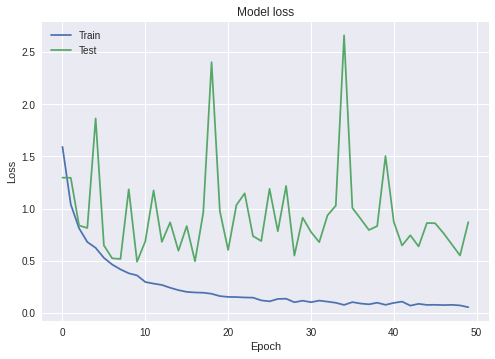

In [ ]:
# Plot the accuracy and loss results
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
y_preds = model.predict(test_data)

32/32 [==============================] - 3s 78ms/step


In [ ]:
y_true = []
y_pred = []
for x, y in test_data:
  y_true = np.concatenate([y_true, np.argmax(y, axis=-1)], axis=0)
  y_pred = np.concatenate([y_pred, np.argmax(model.predict(x), axis=1)], axis=0)

1/1 [==============================] - 0s 29ms/step


In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_true, y_pred)

array([[ 95,   2,   0,   0,   0,   0,   0,   3,   0,   0],
       [  4,  83,   1,   2,   3,   0,   2,   5,   0,   0],
       [  4,   9,  79,   4,   2,   0,   1,   1,   0,   0],
       [  0,   9,   4,  82,   2,   0,   0,   3,   0,   0],
       [  1,   2,   8,   9,  80,   0,   0,   0,   0,   0],
       [  0,   1,   0,   6,   0,  88,   0,   4,   0,   1],
       [  3,   6,   1,   2,   5,  16,  62,   1,   2,   2],
       [  3,   0,   0,   0,   0,   0,   0,  97,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0, 100,   0],
       [  0,   0,   3,   2,   0,   0,   3,   0,   0,  92]])

# Create a function to Visualize the Confusion Matrix

In [ ]:
# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False): 
  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with
  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels,
         )
  
  # Make x-axis labels appear on bottom
  ax.tick_params(axis='x', labelrotation=90)
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

### Plot confusion matrix

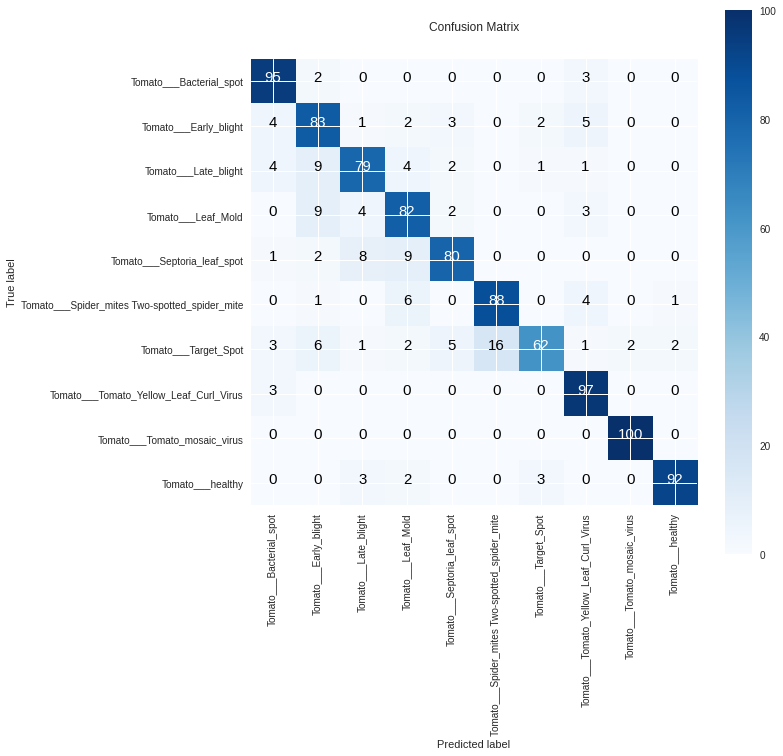

In [ ]:
make_confusion_matrix(y_true, y_pred, class_names)

In [ ]:
print(classification_report(y_true, y_pred, target_names=class_names))

                                               precision    recall  f1-score   support

                      Tomato___Bacterial_spot       0.86      0.95      0.90       100
                        Tomato___Early_blight       0.74      0.83      0.78       100
                         Tomato___Late_blight       0.82      0.79      0.81       100
                           Tomato___Leaf_Mold       0.77      0.82      0.79       100
                  Tomato___Septoria_leaf_spot       0.87      0.80      0.83       100
Tomato___Spider_mites Two-spotted_spider_mite       0.85      0.88      0.86       100
                         Tomato___Target_Spot       0.91      0.62      0.74       100
       Tomato___Tomato_Yellow_Leaf_Curl_Virus       0.85      0.97      0.91       100
                 Tomato___Tomato_mosaic_virus       0.98      1.00      0.99       100
                             Tomato___healthy       0.97      0.92      0.94       100

                                     accu

# Save our Model

In [ ]:
# Save model in h5 format
model.save('cnn_model_h5.h5')

# Load our Model

In [ ]:
# Recreate the exact same model, including its weights and the optimizer
imported_model = tf.keras.models.load_model('cnn_model_h5.h5')

In [ ]:
imported_model.evaluate(test_data)

32/32 [==============================] - 4s 82ms/step - loss: 0.8702 - accuracy: 0.8580


[0.8701997995376587, 0.8579999804496765]

# Model Interpretation

In [ ]:
# Use InceptionV3 to preprocess the data for interpretation
inet_model = inc_net.InceptionV3()

In [ ]:
def transform_img_fn(path_list):
    out = []
    for img_path in path_list:
        img = image.load_img(img_path, target_size=(256, 256))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = inc_net.preprocess_input(x)
        out.append(x)
    return np.vstack(out)

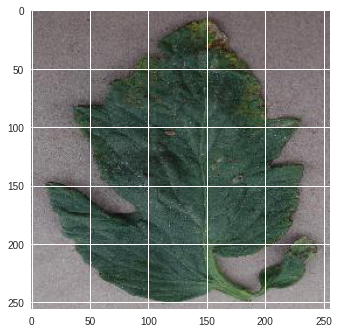

In [ ]:
# Select an image for an example
images = transform_img_fn(['/content/tomato/val/Tomato___Bacterial_spot/01a3cf3f-94c1-44d5-8972-8c509d62558e___GCREC_Bact.Sp 3396.JPG'])

# I'm dividing by 2 and adding 0.5 because of how this Inception represents images
plt.imshow(images[0] / 2 + 0.5)

In [ ]:
# Setup LIME object
explainer = lime_image.LimeImageExplainer()

In [ ]:
# Use our imported model 
explanation = explainer.explain_instance(images[0].astype('double'), imported_model.predict, labels=class_names, top_labels=5, hide_color=0, num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step


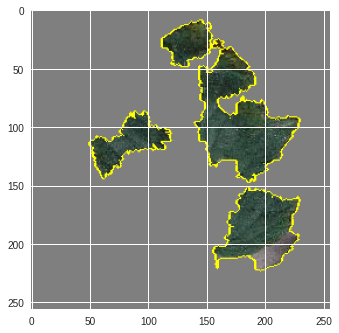

In [ ]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

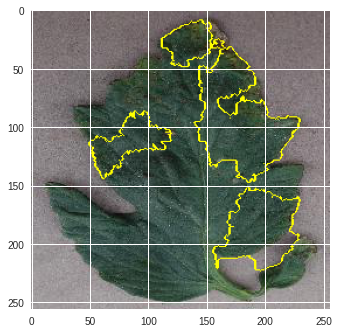

In [ ]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

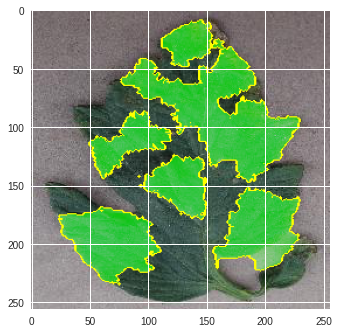

In [ ]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

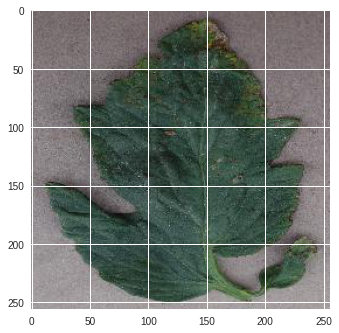

In [ ]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=1000, hide_rest=False, min_weight=0.1)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

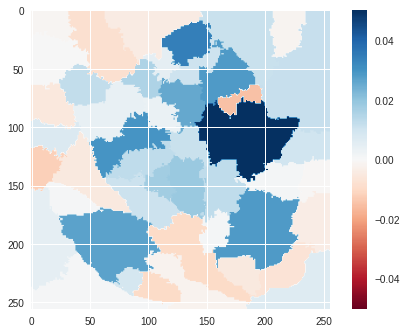

In [ ]:
#Select the same class explained on the figures above.
ind =  explanation.top_labels[0]

#Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 

#Plot. The visualization makes more sense if a symmetrical colorbar is used.
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()

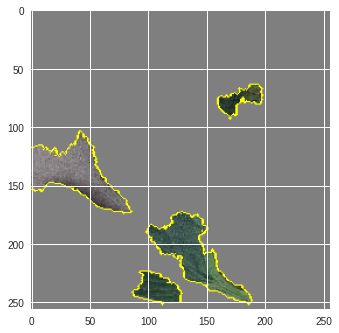

In [ ]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[1], positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

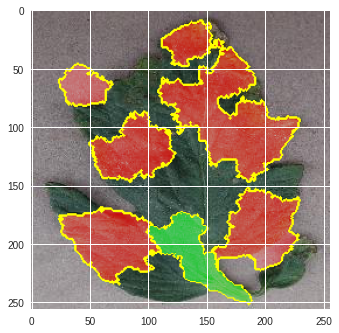

In [ ]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[1], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))